# Mismatch library

# Non-negative Matrix Factorization

In [1]:
# default modules
import sys
import math
import random
import pickle

In [2]:
# external modules
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as tck

In [3]:
# increase figure resolution
plt.rcParams['figure.dpi'] = 100

In [4]:
# custom modules
import analysis_final as analysis
from SliderClass_final import Slider
import graph_final as graph

In [5]:
# working directory
path = "/home/spark159/../../media/spark159/sw/slide_seq_data(2021.07.14)/"

In [6]:
# basic parameters
tlen = 225 # sliding DNA template length
NCPlen = 147 # nucleosomal DNA length

In [7]:
# load WT 601 sliding data
WT_slider1 = pickle.load(open(path+'601_0min'+'.pickle'))['601']
WT_slider2 = pickle.load(open(path+'601_5min'+'.pickle'))['601']

In [8]:
# WT 601 template sequence
WTseq = WT_slider1.seq

In [9]:
# load mismatch library data
mismatch_sliders1 = pickle.load(open(path+'mmlib_bubble_0min_1rep'+'.pickle'))
mismatch_sliders2 = pickle.load(open(path+'mmlib_bubble_5min_1rep'+'.pickle'))

In [10]:
# set target ids
common_ids = list(set(mismatch_sliders1.keys()) & set(mismatch_sliders2.keys()))
target_ids = []
for id in common_ids:
    loc, mtype, nts = id.split('-')
    if len(nts) < 1:
        continue
    if len(nts) > 5:
        continue
    target_ids.append(id)
target_ids = sorted(target_ids, cmp=analysis.wid_cmp_len)

In [11]:
# get nucleosome positioning signal
id_psig1, id_psig2 = {}, {}
for id in target_ids:
    psig1 = mismatch_sliders1[id].get_psig()
    psig2 = mismatch_sliders2[id].get_psig()
    id_psig1[id] = psig1
    id_psig2[id] = psig2

In [12]:
# check NMF approximation error by increasing the dimension
cnum_list = range(1, 21)
error_list1, error_list2 = [], []
for cnum in cnum_list:
    _, _, error1 = analysis.NMF_analysis(id_psig1, cnum=cnum)
    _, _, error2 = analysis.NMF_analysis(id_psig2, cnum=cnum)
    error_list1.append(error1)
    error_list2.append(error2)

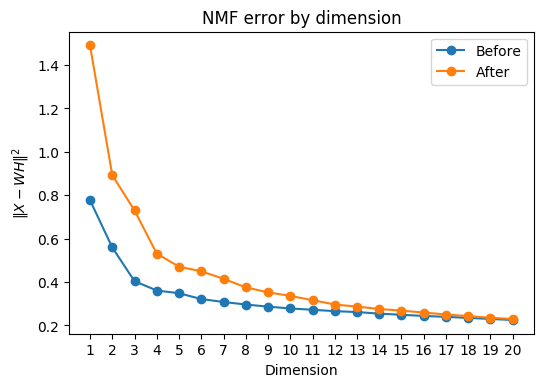

In [13]:
# plot NMF error by dimension
fig = plt.figure()
plt.plot(cnum_list, error_list1, 'o-', label='Before')
plt.plot(cnum_list, error_list2, 'o-', label='After')
plt.title("NMF error by dimension")
plt.xlabel("Dimension")
plt.ylabel("${\Vert X-WH \Vert}^{2} $")
plt.xticks(cnum_list, [str(cnum) for cnum in cnum_list])
plt.legend()
plt.show()
plt.close()

In [14]:
# NMF analysis
cID_basis1, id_weight1, error1 = analysis.NMF_analysis(id_psig1, cnum=3)
cID_basis2, id_weight2, error2 = analysis.NMF_analysis(id_psig2, cnum=4)

In [15]:
# set the name of basis
# before
cID_bname1 = ['hold', 'noisy', 'double-peak']
# after
cID_bname2 = ['2-step', 'back-step', 'hold', '1-step']

NMF basis (Before)
basis 1
hold


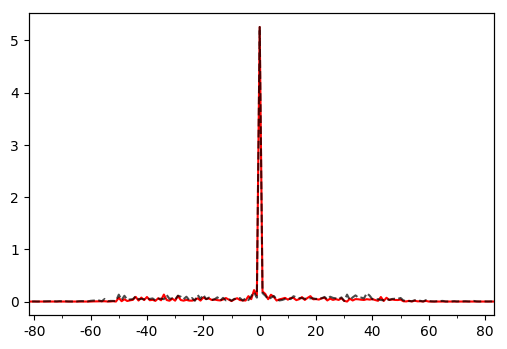

basis 2
noisy


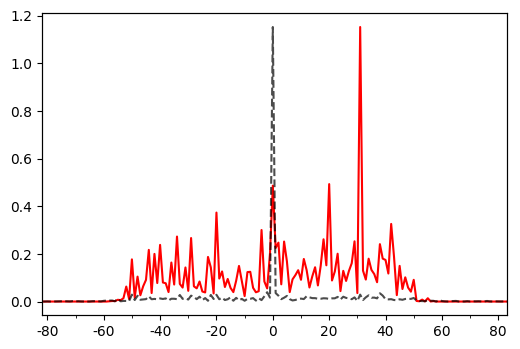

basis 3
double-peak


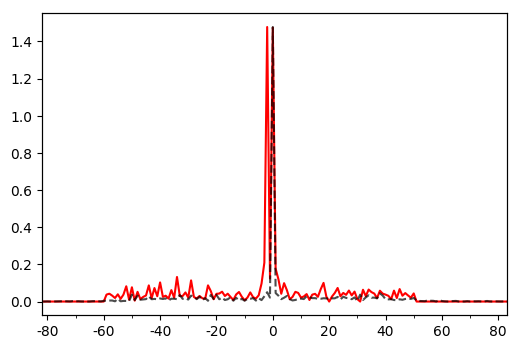

In [16]:
# plot NMF basis (before)
print "NMF basis (Before)"
for cID in range(len(cID_basis1)):
    print "basis", cID+1
    print cID_bname1[cID]
    basis = cID_basis1[cID]
    fig = plt.figure()
    plt.plot(basis, 'r-')
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.plot(WT_slider1.get_psig(), 'k--', alpha=0.7)
    ax2.tick_params(right=False)
    ax2.set_yticks([])
    plt.xticks([i+tlen/2 for i in range(-100, 101, 20)], [str(i) for i in range(-100, 101, 20)])
    plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator(2))
    plt.xlim([30, tlen-30])
    plt.show()
    plt.close

NMF basis (After)
basis 1
2-step


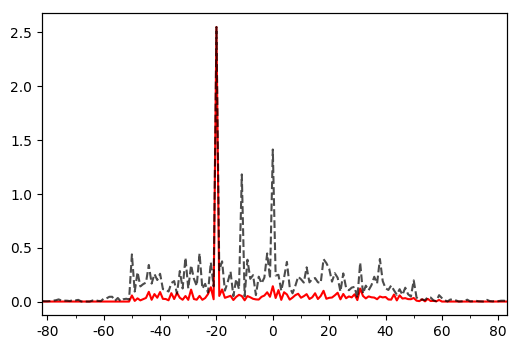

basis 2
back-step


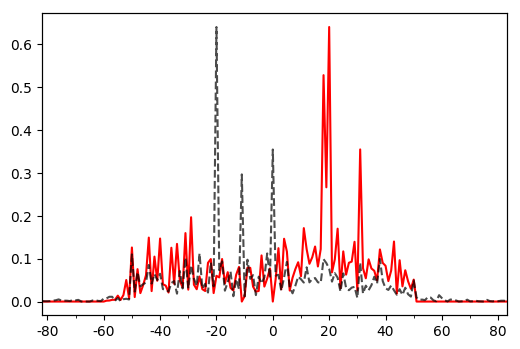

basis 3
hold


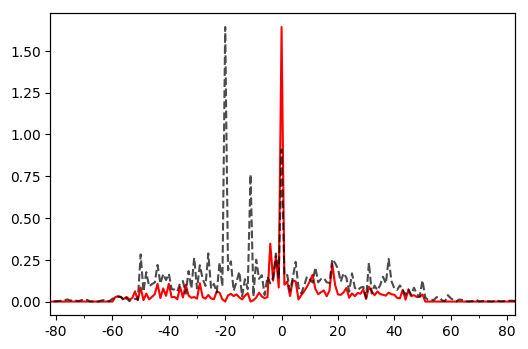

basis 4
1-step


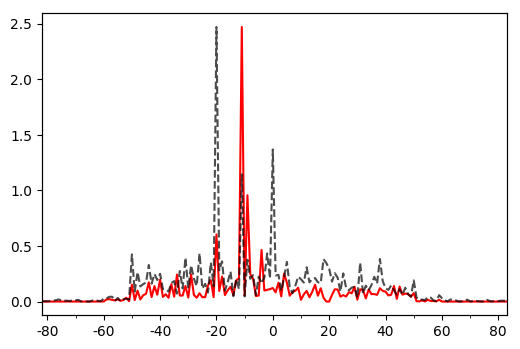

In [17]:
# plot NMF basis (after)
print "NMF basis (After)"
for cID in range(len(cID_basis2)):
    print "basis", cID+1
    print cID_bname2[cID]
    basis = cID_basis2[cID]
    fig = plt.figure()
    plt.plot(basis, 'r-')
    ax = plt.gca()
    ax2 = ax.twinx()
    ax2.plot(WT_slider2.get_psig(), 'k--', alpha=0.7)
    ax2.tick_params(right=False)
    ax2.set_yticks([])
    plt.xticks([i+tlen/2 for i in range(-100, 101, 20)], [str(i) for i in range(-100, 101, 20)])
    plt.gca().xaxis.set_minor_locator(tck.AutoMinorLocator(2))
    plt.xlim([30, tlen-30])
    plt.show()
    plt.close()

In [18]:
# aggregate NMF-weight according to size and location of perturbations
def aggregate_weight (id_weight):
    size_loc_weights = {}
    for id in id_weight.keys():
        loc, mtype, nts = id.split('-')
        size = len(nts)
        if size not in size_loc_weights:
            size_loc_weights[size] = {}
        st = int(loc)
        ed = st+len(nts)
        for i in range(st, ed):
            if i not in size_loc_weights[size]:
                size_loc_weights[size][i] = []
            size_loc_weights[size][i].append(id_weight[id])

    size_loc_meanweight = {}
    for size in size_loc_weights:
        if size not in size_loc_meanweight:
            size_loc_meanweight[size] = {}
        for loc in size_loc_weights[size]:
            meanweight = np.mean(np.asarray(size_loc_weights[size][loc]), axis=0)
            size_loc_meanweight[size][loc] = meanweight

    return size_loc_meanweight

In [19]:
size_loc_meanweight1 = aggregate_weight (id_weight1)
size_loc_meanweight2 = aggregate_weight (id_weight2)

In [20]:
# change template to SHL coordinate
def change_to_shl (size_loc_value):
    size_shl_value = {}
    for size in size_loc_value:
        for loc in size_loc_value[size]:
            shl = loc - tlen/2
            value = size_loc_value[size][loc]
            if size not in size_shl_value:
                size_shl_value[size] = {}
            size_shl_value[size][shl] = value
    return size_shl_value

In [21]:
size_shl_meanweight1 = change_to_shl(size_loc_meanweight1)
size_shl_meanweight2 = change_to_shl(size_loc_meanweight2)

In [22]:
# save the result (before)
fname = path+'mismatchlib_NMF_size_shl_meanweight1'+'.pickle'
pickle.dump(size_shl_meanweight1, open(fname, 'wb'))
# save the result (after)
fname = path+'mismatchlib_NMF_size_shl_meanweight2'+'.pickle'
pickle.dump(size_shl_meanweight2, open(fname, 'wb'))

In [23]:
# plot aggreated weight map
def plot_aggweight_map (size_loc_meanweight, component, cmap='jet'):
    X_list, Y_list, C_list = [], [], []
    for size in size_loc_meanweight:
        for loc in size_loc_meanweight[size]:
            X_list.append(loc+1)
            Y_list.append(size)
            C_list.append(size_loc_meanweight[size][loc][component])
    
    fig = plt.figure(figsize=(20,2))
    plt.scatter(X_list, Y_list, c=C_list, cmap = cmap, vmin=min(C_list), vmax=max(C_list))
    
    sizemin, sizemax = min(size_loc_meanweight.keys()), max(size_loc_meanweight.keys())
    plt.yticks(range(sizemin, sizemax+1, 1), [str(u)for u in range(sizemin, sizemax+1, 1)])
    plt.ylim([sizemin-0.5, sizemax+0.5])
    
    xticklabels = []
    label_count = 0
    TAs = []
    for pos in range(40, tlen-40):
        new_pos = pos - tlen/2
        if abs(new_pos) < 40 and (WTseq[pos:pos+2] == 'TA' or WTseq[pos-1:pos+1] == 'TA'):
            TAs.append(label_count)
        s = WTseq[pos]
        if abs(new_pos) % 10 == 0:
            s+= '\n'
            if new_pos > 0:
                s+= '+' + str(new_pos)
            else:
                s+= str(new_pos)
        xticklabels.append(s)
        label_count+=1
        
    plt.xticks(range(40, tlen-40), xticklabels)
    
    ax = plt.gca()
    for u in TAs:
        tl = ax.get_xticklabels()[u]
        tl.set_fontweight('bold')

    #plt.xlim([40-0.5, tlen-41+0.5])
    plt.xlim([45-0.5, tlen-45+0.5])
    
    cbar = plt.colorbar(pad=0.01)
    cbar.ax.set_ylabel('Weight', rotation=-90, va="bottom", labelpad=-1)
    plt.title("Perturbation map")
    plt.xlabel("Mismatch locations on 601 DNA")
    plt.ylabel('Size (bp)')
    plt.tight_layout()
    plt.show()
    plt.close()

hold


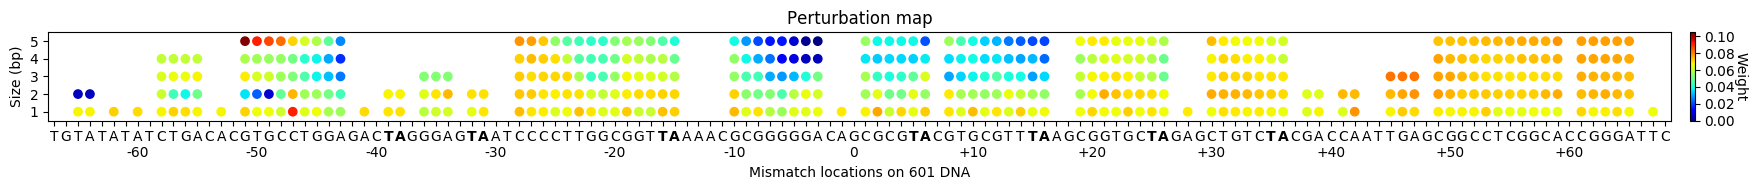

noisy


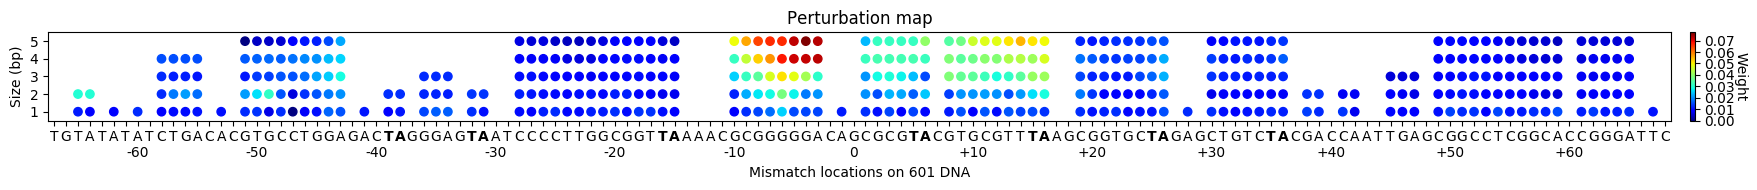

double-peak


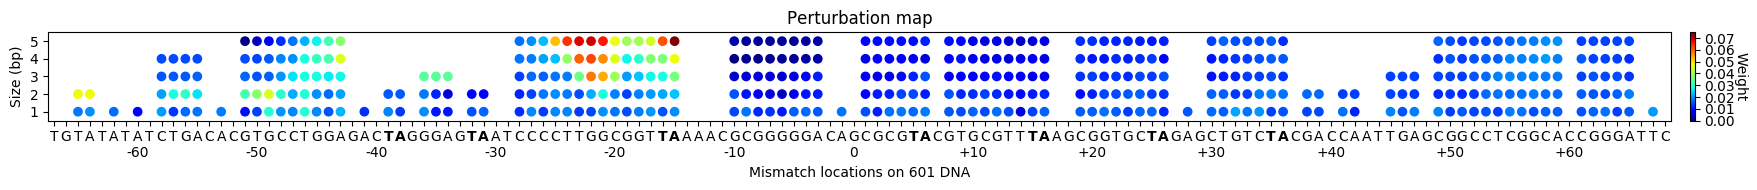

In [24]:
# before sliding
for i in range(3):
    #print "basis %d" % (i+1)
    print cID_bname1[i]
    plot_aggweight_map (size_loc_meanweight1, i)

2-step


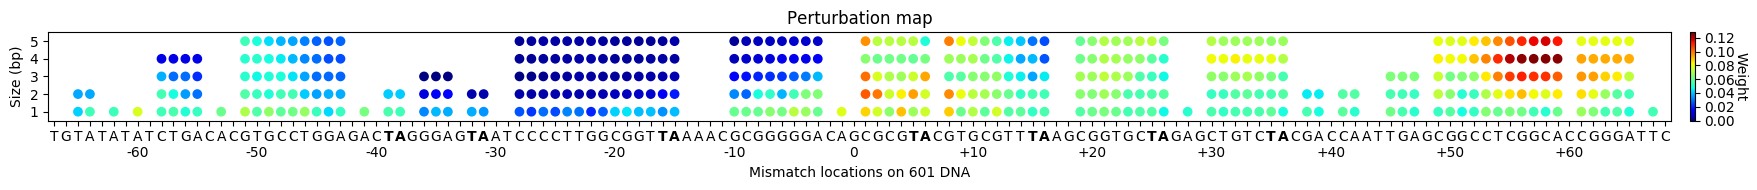

back-step


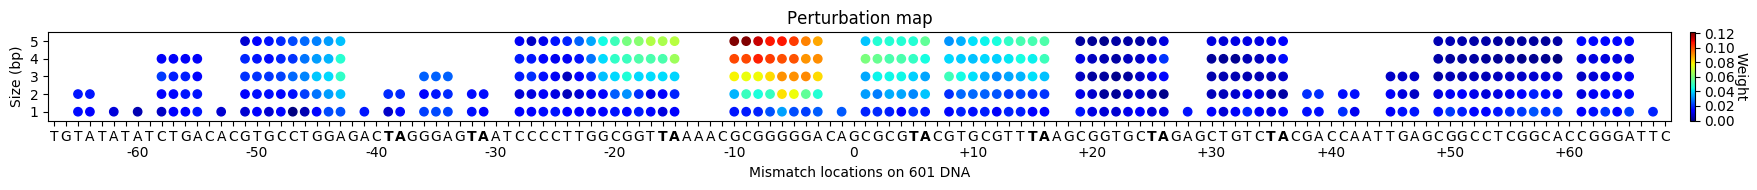

hold


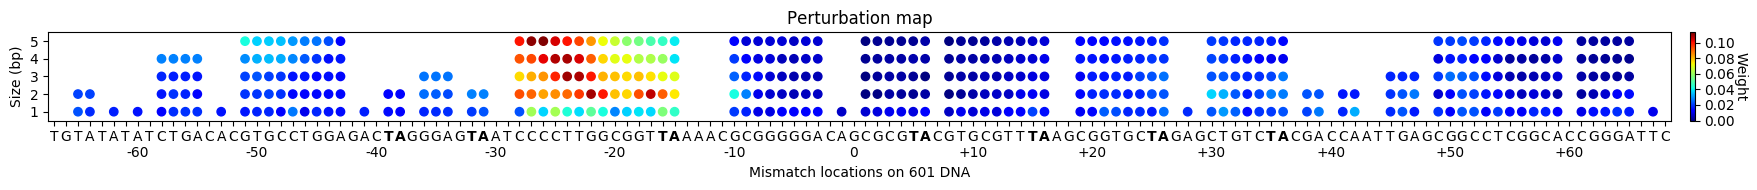

1-step


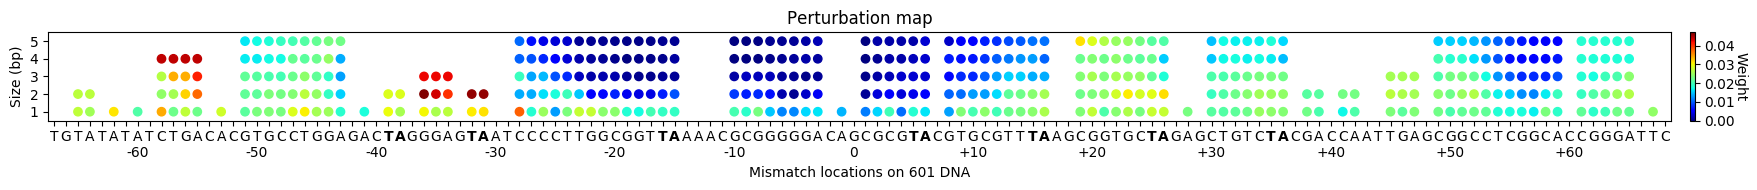

In [25]:
# after sliding
for i in range(4):
    #print "basis %d" % (i+1)
    print cID_bname2[i]
    plot_aggweight_map (size_loc_meanweight2, i)